
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
# !pip install -q pybullet Box2D
# !nvidia-smi

Import necessary packages.

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
from gym.wrappers import RecordVideo
# import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [3]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # TODO: Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_state_memory = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.action_memory = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.reward_memory = np.zeros((buffer_size,1), dtype=np.float32)
        self.done_memory = np.zeros((buffer_size,1), dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        # TODO : Store the transition in the replay buffer
        self.state_memory[self.ptr] = state
        self.action_memory[self.ptr] = action
        self.reward_memory[self.ptr] = reward
        self.next_state_memory[self.ptr] = state_
        self.done_memory[self.ptr] = done
        
        self.ptr = (self.ptr + 1) % self.buffer_size
        self.is_full = (self.ptr == self.buffer_size)


    def load_batch(self, batch_size):
        # TODO: Sample a random batch of transitions from the buffer
        batch_indices = np.random.choice(self.ptr, batch_size, replace=False)
        states = self.state_memory[batch_indices]
        actions = self.action_memory[batch_indices]
        rewards = self.reward_memory[batch_indices]
        states_ = self.next_state_memory[batch_indices]
        done = self.done_memory[batch_indices]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [20]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()
        
        # TODO 1: Save input arguments as attributes
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.ckpt_path = os.path.join(ckpt_dir, name)
        
        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)
        
        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):        
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.ckpt_path = os.path.join(ckpt_dir, name)

        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        
        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.sigma = nn.Linear(fc2_dims, action_dims)
        
        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_sigma = self.sigma(x)
        log_sigma = T.clamp(log_sigma, min=-20, max=2)
        sigma = T.exp(log_sigma)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)
        
        # TODO 8: Create a normal distribution and sample from it
        probabilities = T.distributions.Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample()
        else:
            actions = probabilities.sample()

        action = T.tanh(actions) * T.tensor(self.max_action).to(self.device)
        
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1 - action.pow(2) + 1e-6)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()
        
        # TODO 1: Save arguments as instance variables
        self.ckpt_path = os.path.join(ckpt_dir, name)
        
        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [26]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        
        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.step = 0
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        # TODO 2: Initialize the replay buffer
        self.memory = ReplayBuffer(self.memory_size, self.state_dims, self.action_dims)

        # TODO 3: Initialize Actor and Critic networks
        self.actor = Actor(alpha=alpha, state_dims=state_dims, action_dims=action_dims,
                   fc1_dims=fc1_dim, fc2_dims=fc2_dim, max_action=max_action,
                   reparam_noise=self.reparam_noise_lim,
                   name='actor', ckpt_dir=self.full_path)

        self.critic_1 = Critic(beta=beta, state_dims=state_dims, action_dims=action_dims,
                               fc1_dims=fc1_dim, fc2_dims=fc2_dim, name='critic_1',
                               ckpt_dir=self.full_path)
        self.critic_2 = Critic(beta=beta, state_dims=state_dims, action_dims=action_dims,
                               fc1_dims=fc1_dim, fc2_dims=fc2_dim, name='critic_2',
                               ckpt_dir=self.full_path)


        # TODO 4: Initialize Value and Target Value networks
        self.value = Value(beta=beta, state_dims=state_dims, fc1_dims=fc1_dim,
                           fc2_dims=fc2_dim, name='value', ckpt_dir=self.full_path)
        self.target_value = Value(beta=beta, state_dims=state_dims, fc1_dims=fc1_dim,
                                  fc2_dims=fc2_dim, name='target_value', ckpt_dir=self.full_path)

        # TODO 5: Sync the parameters of value and target_value networks initially
        self.update_parameters(tau=1)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        state = T.tensor(state, dtype=T.float32, device= T.device('cpu')).unsqueeze(0)

        # TODO 7: Choose action from actor
        self.actor.eval()
        with T.no_grad():
            if deterministic:
                mu, _ = self.actor(state)
                action = T.tanh(mu) * self.max_action
                action = action.squeeze(0).cpu().numpy()
                self.actor.train()
                return action
            else:
                action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
                action = action.squeeze(0).cpu().numpy()
                self.actor.train()
                return action
        pass

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)
        self.step += 1

    def load_batch(self):
        states, actions, rewards, states_, dones = self.memory.load_batch(self.batch_size)
        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        dones = T.tensor(dones).to(self.actor.device)
        return states, actions, rewards, states_, dones

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        value_params = self.value.named_parameters()
        target_value_params = self.target_value.named_parameters()

        value_state_dict = dict(value_params)
        target_value_state_dict = dict(target_value_params)

        for name in value_state_dict:
            value_state_dict[name] = tau * value_state_dict[name].clone() + \
                                (1 - tau) * target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)


    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        # TODO 11: Skip learning during warm-up period or insufficient samples
        if self.step < self.warmup or (self.step % self.update_period) != 0 or self.memory.ptr < self.batch_size:
            return

        # === VALUE LOSS ===
        # TODO 12: Load batch and sample action
        states, actions, rewards, next_states, dones = self.load_batch()
        
        # For value target we need current-policy action and log_prob at s
        sample_actions, log_probs = self.actor.sample_normal(states, reparameterize=False)
    
        # TODO 13: Estimate Q-values
        q1_new_policy = self.critic_1(states, sample_actions)
        q2_new_policy = self.critic_2(states, sample_actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        
        # TODO 14: Compute target value
        value_target = critic_value - self.alpha * log_probs

        # TODO 15: Compute value loss and update value network
        v_values = self.value(states)
        value_loss = F.mse_loss(v_values, value_target)
        self.value.optimizer.zero_grad(set_to_none=True)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()
        
        # === ACTOR LOSS ===
        # TODO 16: Re-sample actions (this time with reparameterization for gradients)
        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_new_policy = self.critic_1(states, new_actions)
        q2_new_policy = self.critic_2(states, new_actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        
        # TODO 17: maximize entropy-regularized Q-value
        actor_loss = T.mean(self.alpha * log_probs - critic_value)
        self.actor.optimizer.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor.optimizer.step()
        
        # === CRITIC LOSS ===
        # TODO 18: Compute Q targets
        with T.no_grad():
            target_v = self.target_value(next_states)
            target_v[dones] = 0.0
            q_target = self.reward_scale * rewards + self.gamma * target_v

        # TODO 19: Compute MSE loss for both critics
        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)
        critic1_loss = F.mse_loss(q1, q_target)
        critic2_loss = F.mse_loss(q2, q_target)

        self.critic_1.optimizer.zero_grad(set_to_none=True)
        critic1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad(set_to_none=True)
        critic2_loss.backward()
        self.critic_2.optimizer.step()
        
        # === TARGET NETWORK UPDATE ===
        self.update_parameters()
        # TODO 21: Increase learning iteration counter
        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [14]:
# Configuration parameters

env_name = 'HalfCheetah-v5'
dir = 'tmp'
n_games = 200


gamma = 0.99
alpha = 6e-4
beta = 6e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 10000000
batch_size = 256
tau = 0.006
update_period = 2
reward_scale = 2.
warmup = 15000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

| Game:      0 | Score:    -260.22 | Best score:    -260.22 | Avg score    -260.22 | Learning iter:          0 |
| Game:      1 | Score:    -408.30 | Best score:    -260.22 | Avg score    -334.26 | Learning iter:          0 |
| Game:      2 | Score:    -266.62 | Best score:    -260.22 | Avg score    -311.71 | Learning iter:          0 |
| Game:      3 | Score:    -289.55 | Best score:    -260.22 | Avg score    -306.17 | Learning iter:          0 |
| Game:      4 | Score:    -296.50 | Best score:    -260.22 | Avg score    -304.24 | Learning iter:          0 |
| Game:      5 | Score:    -287.11 | Best score:    -260.22 | Avg score    -301.38 | Learning iter:          0 |
| Game:      6 | Score:    -275.57 | Best score:    -260.22 | Avg score    -297.70 | Learning iter:          0 |
| Game:      7 | Score:    -217.08 | Best score:    -217.08 | Avg score    -287.62 | Learning iter:          0 |
| Game:      8 | Score:    -243.17 | Best score:    -217.08 | Avg score    -282.68 | Learning it

MoviePy - Done !
MoviePy - video ready c:\Users\Mahdi\Desktop\AIPROJ\tmp\HalfCheetah-v5\videos\rl-video-episode-199.mp4
| Game:    199 | Score:    4401.60 | Best score:    4609.47 | Avg score    4199.29 | Learning iter:      92501 |
... saving checkpoint ...


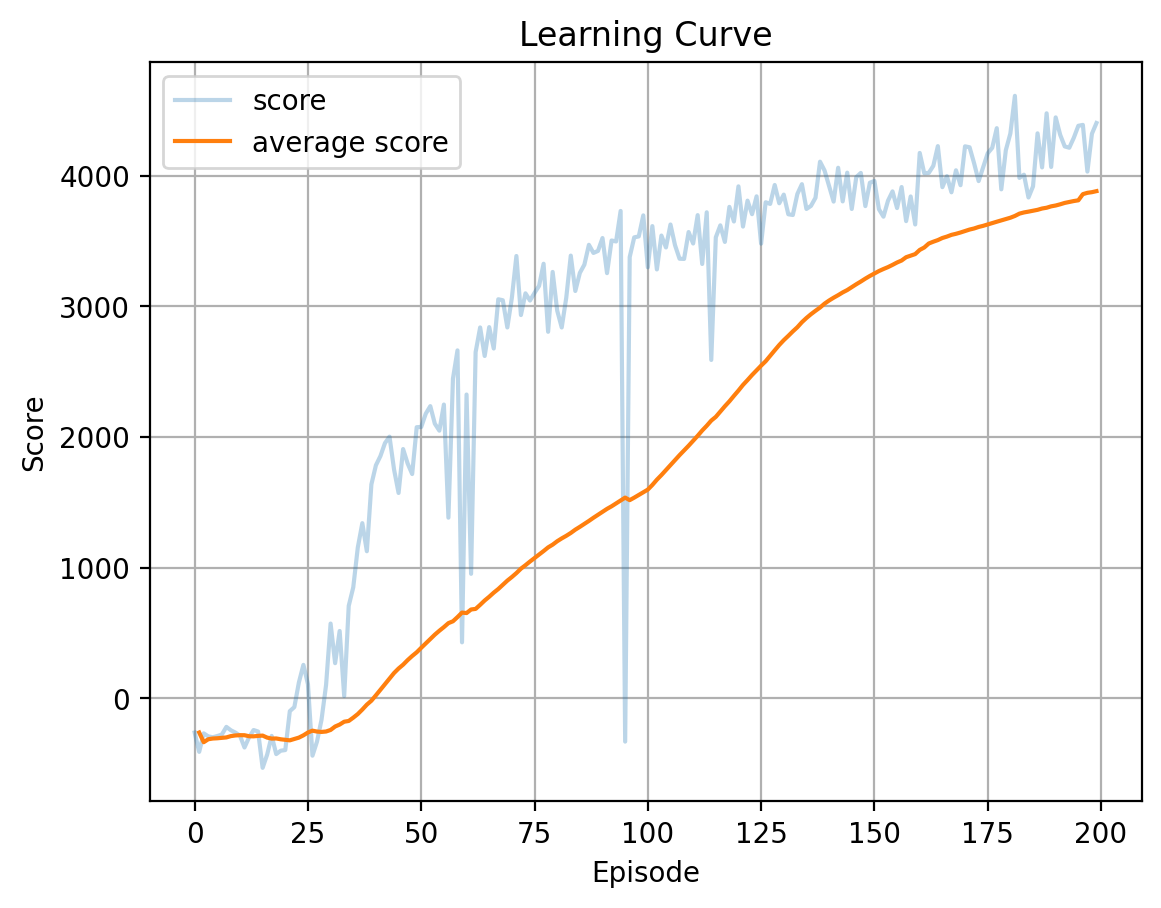

In [27]:
import gymnasium
env = gymnasium.make(env_name, render_mode="rgb_array")
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta,
              state_dims=env.observation_space.shape[0],
              action_dims=env.action_space.shape[0],
              max_action=env.action_space.high,
              fc1_dim=fc1_dim, fc2_dim=fc2_dim,
              memory_size=memory_size, batch_size=batch_size,
              tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup,
              reparam_noise_lim=reparam_noise_lim,
              name=env_name, ckpt_dir=dir_path)


# TODO: Initialize performance tracking variables
scores = []
best_score = -np.inf
avg_score = 0


for game in range(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    state , _= env.reset()
    done = False
    score = 0

    # TODO: Interact with the environment until the episode is done
    while not done:
        # 1. Choose an action using the agent's policy
        action = agent.choose_action(state)
        # 2. Take the action in the environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # 3. Store the transition in the replay buffer
        agent.store_transition(state, action, reward, next_state, done)
        # 4. Update the agent's networks
        agent.learn()
        # 5. Update the state and episode score
        state = next_state
        score += reward


    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-30:]) if len(scores) >= 30 else np.mean(scores)
    best_score = max(best_score, score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    
    # TODO: Save the model if the current avg score is better than the best so far
    if avg_score > best_score:
        agent.save_model()

env.close()
agent.save_model()
plot_learning_curve(scores, agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [28]:
Video(f".\\tmp\\HalfCheetah-v5\\videos\\rl-video-episode-{n_games-1}.mp4", embed=True, width=600)